# Diabetes Dataset Classification with Fuzzy Rough Sets

This notebook demonstrates how to use the Eddy library (Fuzzy LEM2) for diabetes classification.

## Dataset Information
- **Pima Indians Diabetes Dataset**
- **8 continuous features** (medical measurements)
- **2 classes**: tested_positive, tested_negative

## What is Fuzzy LEM2?
LEM2 (Learning from Examples Module 2) is a rule induction algorithm based on rough set theory. The fuzzy extension handles continuous data by using fuzzy membership degrees.

## 1. Setup and Imports

In [5]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

# Eddy library imports
from eddy.fuzzylem import FuzzyLEM2Classifier

# Configure plotting
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print("✅ Imports successful!")

✅ Imports successful!


## 2. Load and Explore the Dataset

In [6]:
# Load the diabetes dataset
# Replace 'diabetes.csv' with your actual file path
df = pd.read_csv('data/pima768(8_0_0)2.csv')

# Check actual column names
print("Original columns:", df.columns.tolist())

# Rename columns to remove (R) and (N) suffixes for easier handling
df.columns = df.columns.str.replace(r'\(R\)', '', regex=True)
df.columns = df.columns.str.replace(r'\(N\)', '', regex=True)

print(f"\nDataset shape: {df.shape}")
print(f"Samples: {df.shape[0]}")
print(f"Features: {df.shape[1] - 1}")
print(f"\n📊 First few rows:")
df.head()

Original columns: ['Preg(R)', 'Plas(R)', 'Pres(R)', 'Skin(R)', 'Insu(R)', 'Mass(R)', 'Pedi(R)', 'Age(R)', 'Class(N)']

Dataset shape: (768, 9)
Samples: 768
Features: 8

📊 First few rows:


,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age,Class
0,14,175,62,30,0,33.6,0.212,38,tested_positive
1,4,146,78,0,0,38.5,0.520,67,tested_positive
2,15,136,70,32,110,37.1,0.153,43,tested_positive
3,3,107,62,13,48,22.9,0.678,23,tested_positive
4,3,169,74,19,125,29.9,0.268,31,tested_positive


In [7]:
# Feature names (after removing suffixes)
feature_names = [
    'Preg', 'Plas', 'Pres', 'Skin', 'Insu', 'Mass', 'Pedi', 'Age'
]

feature_full_names = [
    'Pregnancies', 'Plasma Glucose', 'Blood Pressure', 'Skin Thickness',
    'Insulin', 'BMI', 'Diabetes Pedigree', 'Age'
]

class_names = ['tested_negative', 'tested_positive']

# Encode class labels (Class column after removing (N) suffix)
df['Class_Encoded'] = df['Class'].map({'tested_negative': 0, 'tested_positive': 1})

print("\n📋 Dataset Info:")
print(df.info())
print("\n✅ Column names cleaned and class labels encoded!")


📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Preg           768 non-null    int64  
 1   Plas           768 non-null    int64  
 2   Pres           768 non-null    int64  
 3   Skin           768 non-null    int64  
 4   Insu           768 non-null    int64  
 5   Mass           768 non-null    float64
 6   Pedi           768 non-null    float64
 7   Age            768 non-null    int64  
 8   Class          768 non-null    object 
 9   Class_Encoded  768 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 60.1+ KB
None

✅ Column names cleaned and class labels encoded!


## 3. Data Exploration and Visualization

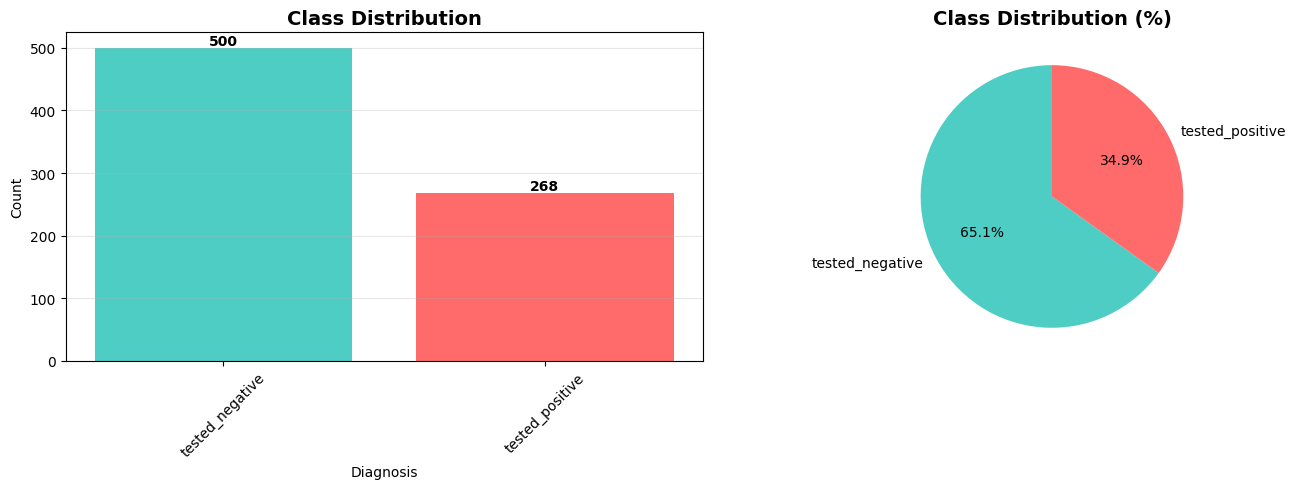


📈 Class Statistics:
    tested_negative: 500 samples ( 65.1%)
    tested_positive: 268 samples ( 34.9%)


In [8]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
class_counts = df['Class'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=['#4ECDC4', '#FF6B6B'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diagnosis')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, (name, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 5, str(count), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=['#4ECDC4', '#FF6B6B'], startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Class Statistics:")
for name in class_counts.index:
    count = class_counts[name]
    percentage = count / len(df) * 100
    print(f"   {name:>16s}: {count:3d} samples ({percentage:5.1f}%)")

In [9]:
# Feature statistics
print("\n📊 Feature Statistics:")
df[feature_names].describe()


📊 Feature Statistics:


,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [10]:
# Check for missing values (zeros that might represent missing data)
print("\n⚠️ Zero Values Check (may indicate missing data):")
zero_counts = (df[feature_names] == 0).sum()
for feature, count in zero_counts.items():
    if count > 0:
        percentage = count / len(df) * 100
        print(f"   {feature:>20s}: {count:3d} zeros ({percentage:5.1f}%)")


⚠️ Zero Values Check (may indicate missing data):
                   Preg: 111 zeros ( 14.5%)
                   Plas:   5 zeros (  0.7%)
                   Pres:  35 zeros (  4.6%)
                   Skin: 227 zeros ( 29.6%)
                   Insu: 374 zeros ( 48.7%)
                   Mass:  11 zeros (  1.4%)


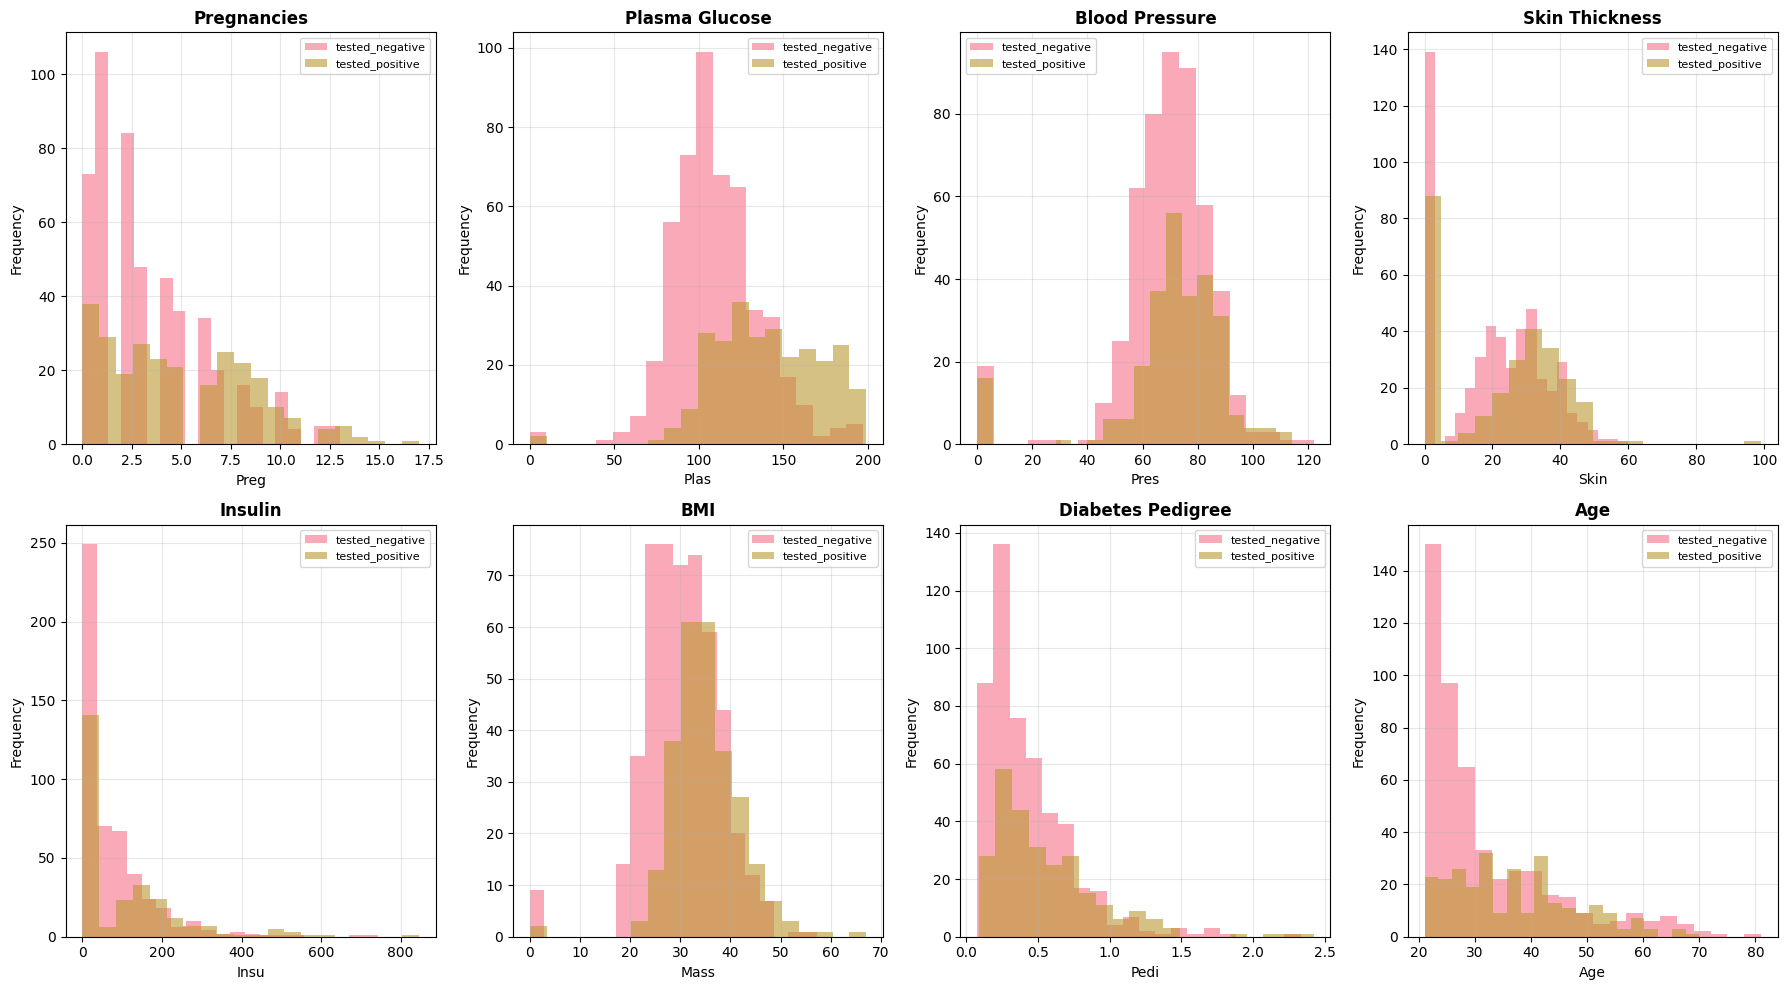

In [11]:
# Visualize all features by class
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, (feature, full_name) in enumerate(zip(feature_names, feature_full_names)):
    for class_name in class_names:
        data_subset = df[df['Class'] == class_name][feature]
        axes[idx].hist(data_subset, alpha=0.6, label=class_name, bins=20)
    
    axes[idx].set_title(f'{full_name}', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

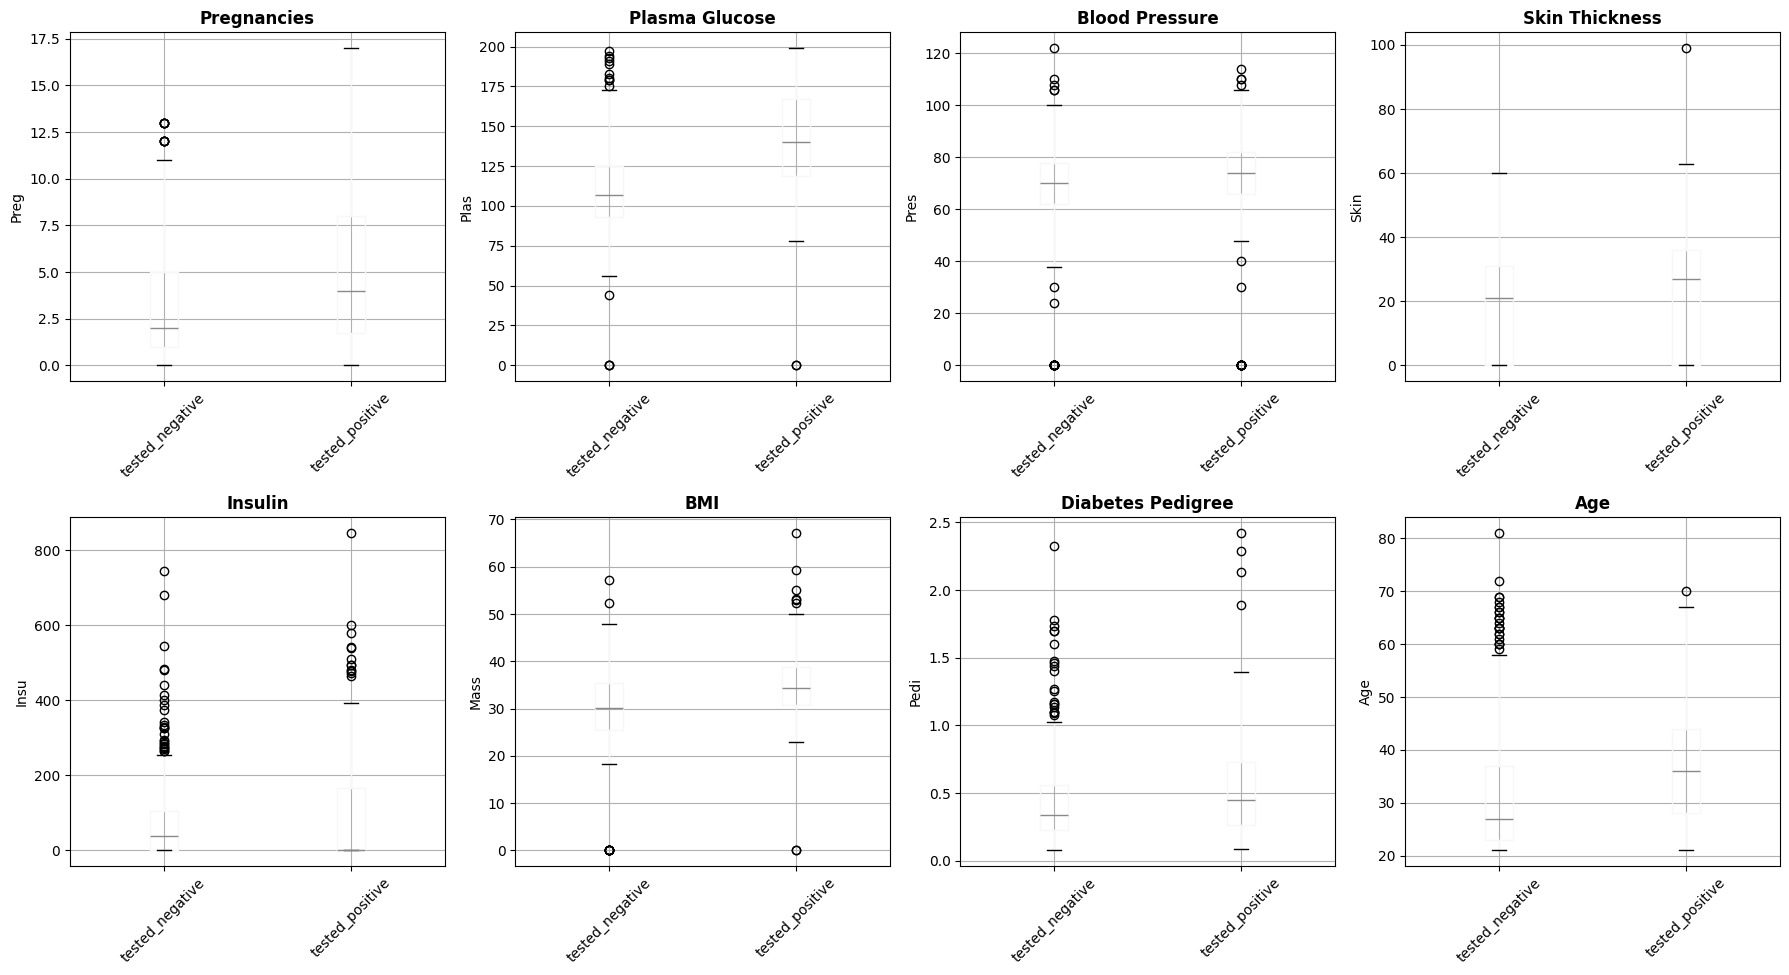

In [12]:
# Box plots by class
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, (feature, full_name) in enumerate(zip(feature_names, feature_full_names)):
    df.boxplot(column=feature, by='Class', ax=axes[idx])
    axes[idx].set_title(f'{full_name}', fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel(feature)
    plt.sca(axes[idx])
    plt.xticks(rotation=45)

plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.show()

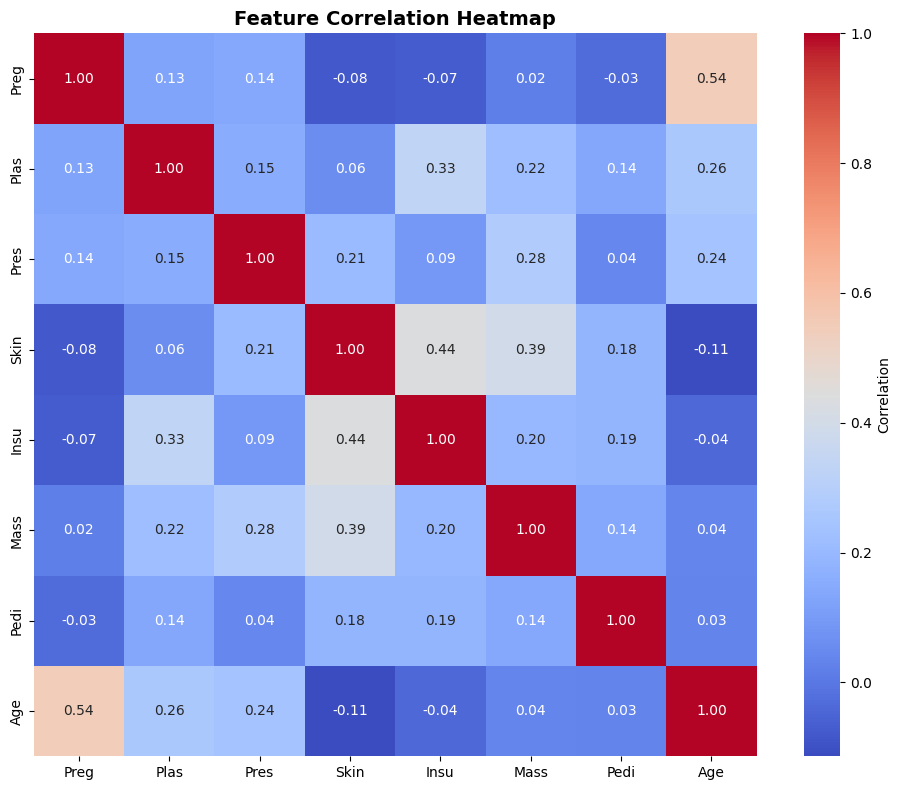

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={'label': 'Correlation'},
            xticklabels=feature_names, yticklabels=feature_names)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preparation

In [14]:
# Prepare features and labels
X = df[feature_names].values
y = df['Class_Encoded'].values

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for class_idx, count in train_dist.items():
    print(f"   {class_names[int(class_idx)]}: {count} samples")

Training set: 537 samples
Testing set: 231 samples

Training class distribution:
   tested_negative: 350 samples
   tested_positive: 187 samples


## 5. Train Fuzzy LEM2 Classifier

### Parameters Explanation:
- **alpha** (0.05): Dependency threshold - controls how strict the rules are
  - Lower values → stricter rules (fewer false positives)
  - Higher values → more lenient rules (better coverage)
  
- **beta** (0.2): Covering threshold - controls how precisely rules must cover the concept
  - Lower values → more precise covering required
  - Higher values → allows partial covering

In [15]:
# Initialize the classifier
clf = FuzzyLEM2Classifier(alpha=0.05, beta=0.2)

print("🤖 Training Fuzzy LEM2 Classifier...")
print("⏳ This may take a few minutes...\n")

# Train the model
clf.fit(X_train, y_train)

print("\n✅ Training complete!")

🤖 Training Fuzzy LEM2 Classifier...
⏳ This may take a few minutes...

{frozenset({(6, np.float64(1.699))})}
{frozenset({(3, np.float64(63.0))})}

✅ Training complete!


In [16]:
# Analyze the generated rules
print("\n📋 Generated Rules Summary:")
print("-" * 40)

total_rules = 0
for class_idx, class_name in enumerate(class_names):
    rules = clf.rules_[class_idx]
    num_rules = len(rules)
    total_rules += num_rules
    print(f"{class_name:>16s}: {num_rules:3d} rule complexes")

print("-" * 40)
print(f"{'Total':>16s}: {total_rules:3d} rule complexes")


📋 Generated Rules Summary:
----------------------------------------
 tested_negative:   1 rule complexes
 tested_positive:   1 rule complexes
----------------------------------------
           Total:   2 rule complexes


## 6. Make Predictions and Evaluate

In [17]:
# Make predictions on test set
print("🔮 Making predictions on test set...")
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 Overall Accuracy: {accuracy:.2%}")

🔮 Making predictions on test set...

🎯 Overall Accuracy: 46.32%


In [18]:
# Detailed classification report
print("\n" + "="*70)
print("📈 CLASSIFICATION REPORT")
print("="*70)
print()
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))


📈 CLASSIFICATION REPORT

                 precision    recall  f1-score   support

tested_negative      0.627     0.427     0.508       150
tested_positive      0.333     0.531     0.410        81

       accuracy                          0.463       231
      macro avg      0.480     0.479     0.459       231
   weighted avg      0.524     0.463     0.473       231



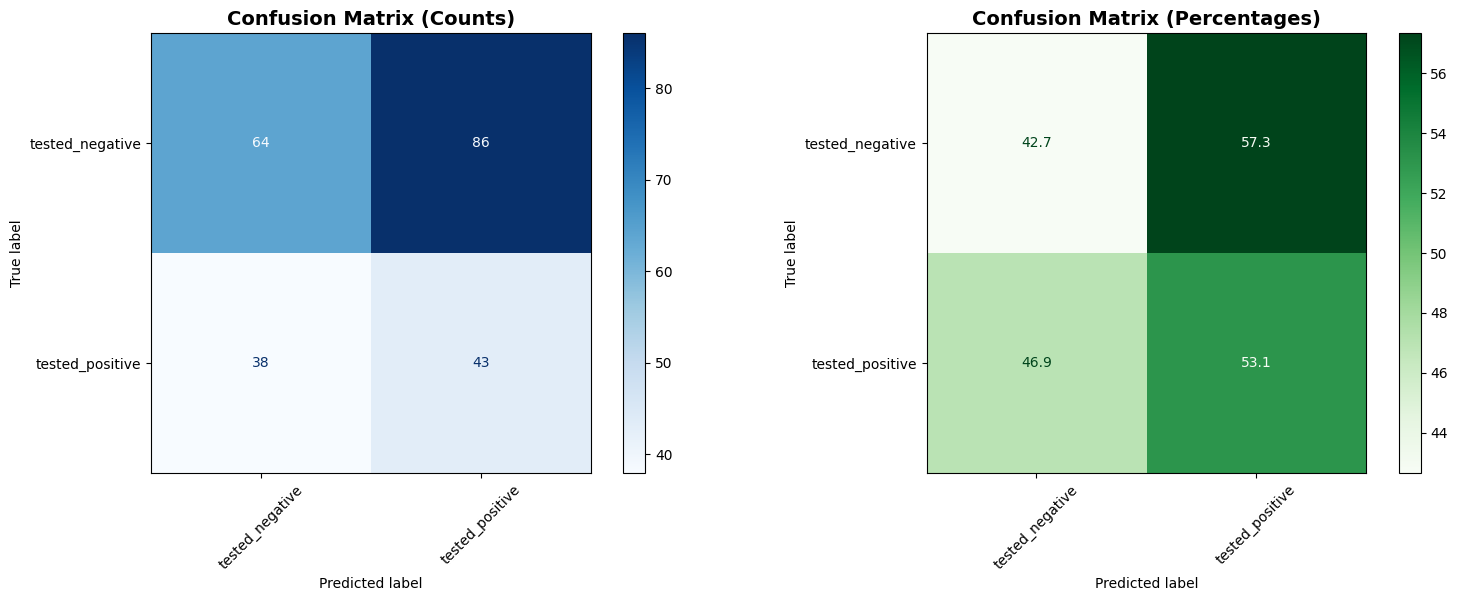

In [19]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix - counts
cm = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Confusion matrix - percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Greens', values_format='.1f')
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


📊 Per-Class Performance:
----------------------------------------------------------------------
 tested_negative: Acc=42.67%, Prec=62.75%, Rec=42.67%, F1=0.508
 tested_positive: Acc=53.09%, Prec=33.33%, Rec=53.09%, F1=0.410

🏥 Medical Interpretation:
   Sensitivity (True Positive Rate): 53.09%
   Specificity (True Negative Rate): 42.67%
   Positive Predictive Value (PPV):  33.33%
   Negative Predictive Value (NPV):  62.75%


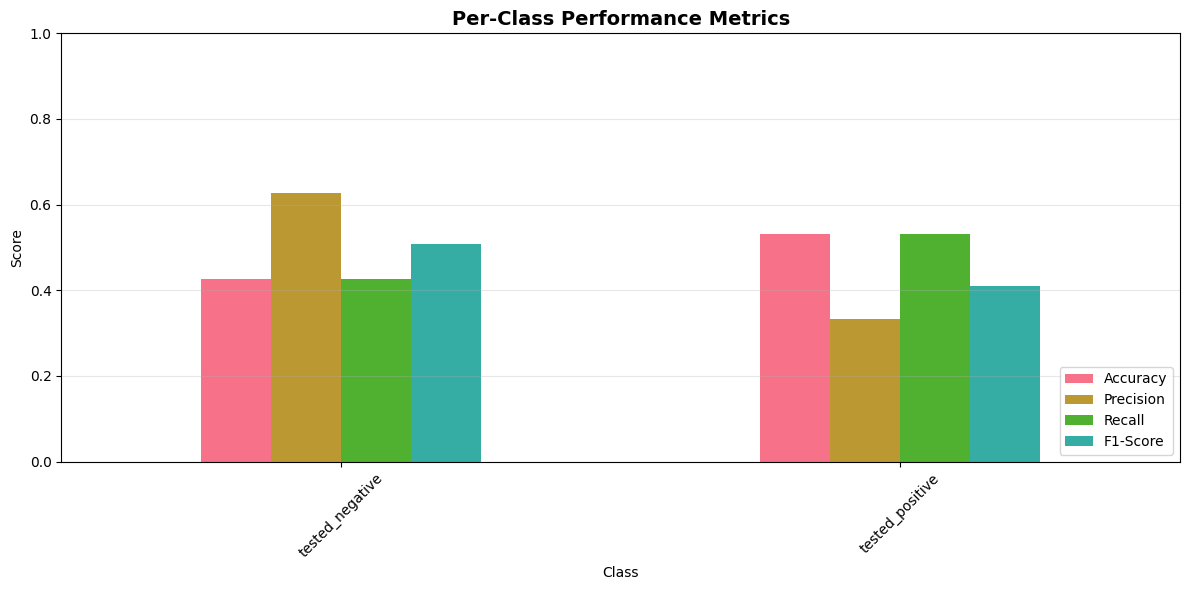

In [20]:
# Per-class performance with medical context
print("\n📊 Per-Class Performance:")
print("-" * 70)

cm = confusion_matrix(y_test, y_pred)
per_class_data = []

for i, name in enumerate(class_names):
    tp = cm[i, i]
    total = cm[i].sum()
    accuracy_class = tp / total if total > 0 else 0
    
    # Calculate precision and recall
    precision = tp / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = accuracy_class
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    per_class_data.append({
        'Class': name,
        'Accuracy': accuracy_class,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"{name:>16s}: Acc={accuracy_class:.2%}, Prec={precision:.2%}, Rec={recall:.2%}, F1={f1:.3f}")

# Medical interpretation
print("\n🏥 Medical Interpretation:")
print(f"   Sensitivity (True Positive Rate): {per_class_data[1]['Recall']:.2%}")
print(f"   Specificity (True Negative Rate): {per_class_data[0]['Recall']:.2%}")
print(f"   Positive Predictive Value (PPV):  {per_class_data[1]['Precision']:.2%}")
print(f"   Negative Predictive Value (NPV):  {per_class_data[0]['Precision']:.2%}")

# Visualize per-class performance
perf_df = pd.DataFrame(per_class_data)
perf_df.set_index('Class')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(12, 6), rot=45
)
plt.title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Example Predictions

In [21]:
# Show some example predictions
print("\n🔍 Example Predictions (First 20 test samples):")
print("-" * 70)
print(f"{'Sample':>6} | {'True':>16} | {'Predicted':>16} | {'Correct':>7}")
print("-" * 70)

for i in range(min(20, len(y_test))):
    true_class = class_names[int(y_test[i])]
    pred_class = class_names[int(y_pred[i])]
    correct = "✓" if y_test[i] == y_pred[i] else "✗"
    print(f"{i+1:>6} | {true_class:>16} | {pred_class:>16} | {correct:>7}")


🔍 Example Predictions (First 20 test samples):
----------------------------------------------------------------------
Sample |             True |        Predicted | Correct
----------------------------------------------------------------------
     1 |  tested_positive |  tested_negative |       ✗
     2 |  tested_positive |  tested_positive |       ✓
     3 |  tested_positive |  tested_positive |       ✓
     4 |  tested_positive |  tested_negative |       ✗
     5 |  tested_positive |  tested_positive |       ✓
     6 |  tested_negative |  tested_positive |       ✗
     7 |  tested_negative |  tested_negative |       ✓
     8 |  tested_negative |  tested_positive |       ✗
     9 |  tested_negative |  tested_positive |       ✗
    10 |  tested_negative |  tested_negative |       ✓
    11 |  tested_negative |  tested_negative |       ✓
    12 |  tested_negative |  tested_positive |       ✗
    13 |  tested_negative |  tested_negative |       ✓
    14 |  tested_negative |  tested_nega

## 8. Feature Importance Analysis

In [22]:
# Analyze which features appear most in rules
print("\n📊 Feature Usage in Rules:")
print("This shows how often each feature appears in the generated rules.\n")

# Note: This is a simplified analysis. The actual implementation would depend
# on how the FuzzyLEM2Classifier stores its rules internally.
print("(Feature importance analysis would require inspection of rule structures)")


📊 Feature Usage in Rules:
This shows how often each feature appears in the generated rules.

(Feature importance analysis would require inspection of rule structures)


## 9. Parameter Tuning Experiment (Optional)

**Warning**: This section will take a long time to run! Feel free to skip it or reduce the parameter ranges.

In [23]:
# Test different parameter combinations
alpha_values = [0.01, 0.05, 0.1, 0.15]
beta_values = [0.1, 0.2, 0.3, 0.4]

results = []

print("🔬 Testing different parameter combinations...\n")
print("This will take several minutes...\n")

for alpha in alpha_values:
    for beta in beta_values:
        print(f"Testing alpha={alpha}, beta={beta}...", end=" ")
        
        try:
            clf_test = FuzzyLEM2Classifier(alpha=alpha, beta=beta)
            clf_test.fit(X_train, y_train)
            y_pred_test = clf_test.predict(X_test)
            acc = accuracy_score(y_test, y_pred_test)
            
            results.append({
                'alpha': alpha,
                'beta': beta,
                'accuracy': acc
            })
            
            print(f"Accuracy: {acc:.2%}")
        except Exception as e:
            print(f"Failed: {e}")

print("\n✅ Parameter tuning complete!")

🔬 Testing different parameter combinations...

This will take several minutes...

Testing alpha=0.01, beta=0.1... {frozenset({(6, np.float64(1.781))})}
{frozenset({(6, np.float64(1.698)), (6, np.float64(1.6))})}
Accuracy: 35.50%
Testing alpha=0.01, beta=0.2... {frozenset({(6, np.float64(1.781))})}
{frozenset({(6, np.float64(1.698)), (6, np.float64(1.6))})}
Accuracy: 35.50%
Testing alpha=0.01, beta=0.3... {frozenset({(6, np.float64(1.781))})}
{frozenset({(6, np.float64(1.698)), (6, np.float64(1.6))})}
Accuracy: 35.50%
Testing alpha=0.01, beta=0.4... set()
{frozenset({(6, np.float64(1.698)), (6, np.float64(1.6))})}
Accuracy: 35.06%
Testing alpha=0.05, beta=0.1... {frozenset({(6, np.float64(1.699))})}
{frozenset({(3, np.float64(63.0))})}
Accuracy: 46.32%
Testing alpha=0.05, beta=0.2... {frozenset({(6, np.float64(1.699))})}
{frozenset({(3, np.float64(63.0))})}
Accuracy: 46.32%
Testing alpha=0.05, beta=0.3... {frozenset({(6, np.float64(1.699))})}
{frozenset({(3, np.float64(63.0))})}
Accurac

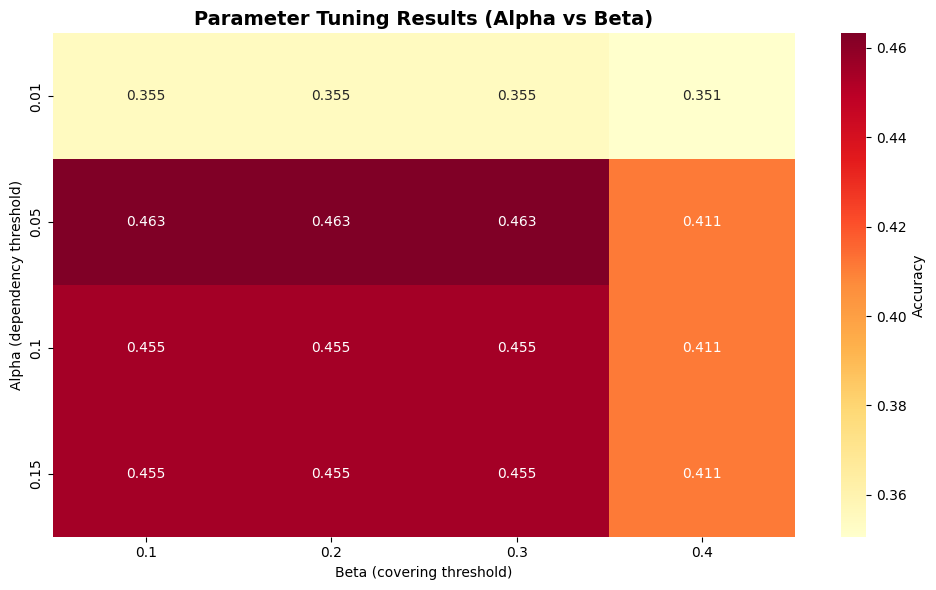


🏆 Best Parameters:
   Alpha: 0.05
   Beta: 0.1
   Accuracy: 46.32%


In [24]:
# Visualize parameter tuning results
if results:
    results_df = pd.DataFrame(results)
    
    # Create pivot table for heatmap
    pivot_table = results_df.pivot(index='alpha', columns='beta', values='accuracy')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
                cbar_kws={'label': 'Accuracy'})
    plt.title('Parameter Tuning Results (Alpha vs Beta)', fontsize=14, fontweight='bold')
    plt.xlabel('Beta (covering threshold)')
    plt.ylabel('Alpha (dependency threshold)')
    plt.tight_layout()
    plt.show()
    
    # Find best parameters
    best_result = results_df.loc[results_df['accuracy'].idxmax()]
    print(f"\n🏆 Best Parameters:")
    print(f"   Alpha: {best_result['alpha']}")
    print(f"   Beta: {best_result['beta']}")
    print(f"   Accuracy: {best_result['accuracy']:.2%}")

## 10. Comparison with Other Classifiers

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Train different classifiers
classifiers = {
    'Fuzzy LEM2': clf,
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

comparison_results = []

print("🔬 Comparing with other classifiers...\n")

for name, classifier in classifiers.items():
    if name != 'Fuzzy LEM2':
        print(f"Training {name}...", end=" ")
        classifier.fit(X_train, y_train)
        print("Done.")
    
    y_pred_comp = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred_comp)
    
    # Calculate additional metrics
    cm_comp = confusion_matrix(y_test, y_pred_comp)
    sensitivity = cm_comp[1,1] / cm_comp[1].sum() if cm_comp[1].sum() > 0 else 0
    specificity = cm_comp[0,0] / cm_comp[0].sum() if cm_comp[0].sum() > 0 else 0
    
    comparison_results.append({
        'Classifier': name,
        'Accuracy': acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    })

print("\n✅ Comparison complete!")

🔬 Comparing with other classifiers...

Training Random Forest... Done.
Training SVM... Done.
Training K-Nearest Neighbors... Done.
Training Naive Bayes... Done.
Training Logistic Regression... Done.
Training Decision Tree... Done.

✅ Comparison complete!


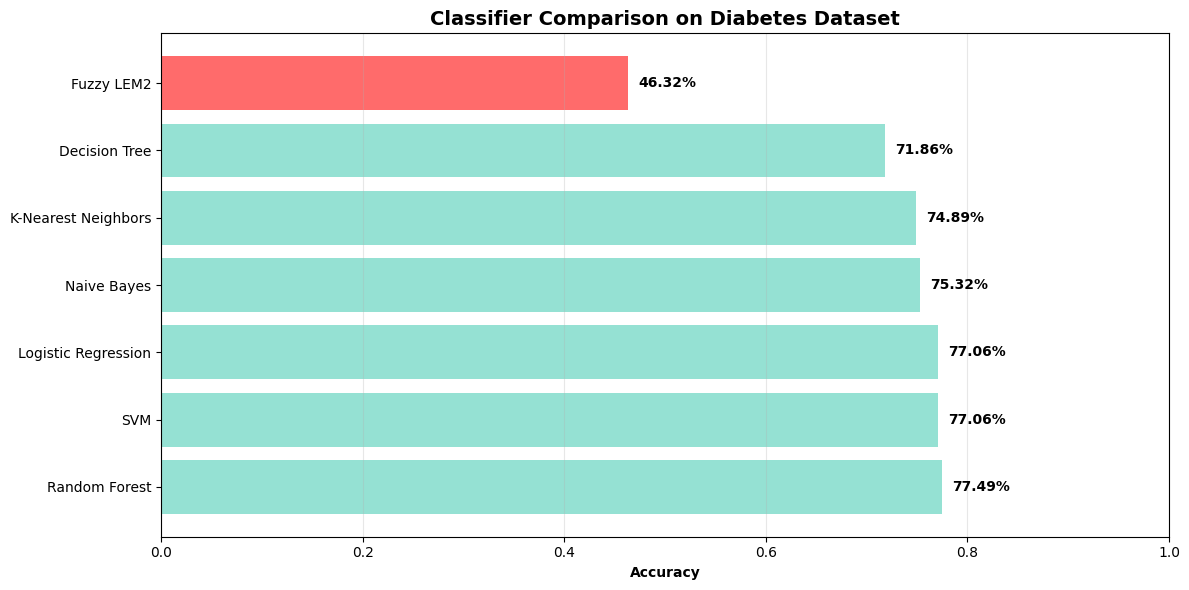


📊 Classifier Rankings:
         Classifier  Accuracy  Sensitivity  Specificity
      Random Forest  0.774892     0.617284     0.860000
                SVM  0.770563     0.469136     0.933333
Logistic Regression  0.770563     0.555556     0.886667
        Naive Bayes  0.753247     0.604938     0.833333
K-Nearest Neighbors  0.748918     0.555556     0.853333
      Decision Tree  0.718615     0.592593     0.786667
         Fuzzy LEM2  0.463203     0.530864     0.426667


In [26]:
# Visualize comparison
comp_df = pd.DataFrame(comparison_results).sort_values('Accuracy', ascending=False)

# Bar plot for accuracy
plt.figure(figsize=(12, 6))
colors = ['#FF6B6B' if x == 'Fuzzy LEM2' else '#95E1D3' for x in comp_df['Classifier']]
bars = plt.barh(comp_df['Classifier'], comp_df['Accuracy'], color=colors)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, comp_df['Accuracy'])):
    plt.text(acc + 0.01, i, f'{acc:.2%}', va='center', fontweight='bold')

plt.xlabel('Accuracy', fontweight='bold')
plt.title('Classifier Comparison on Diabetes Dataset', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Classifier Rankings:")
print(comp_df.to_string(index=False))

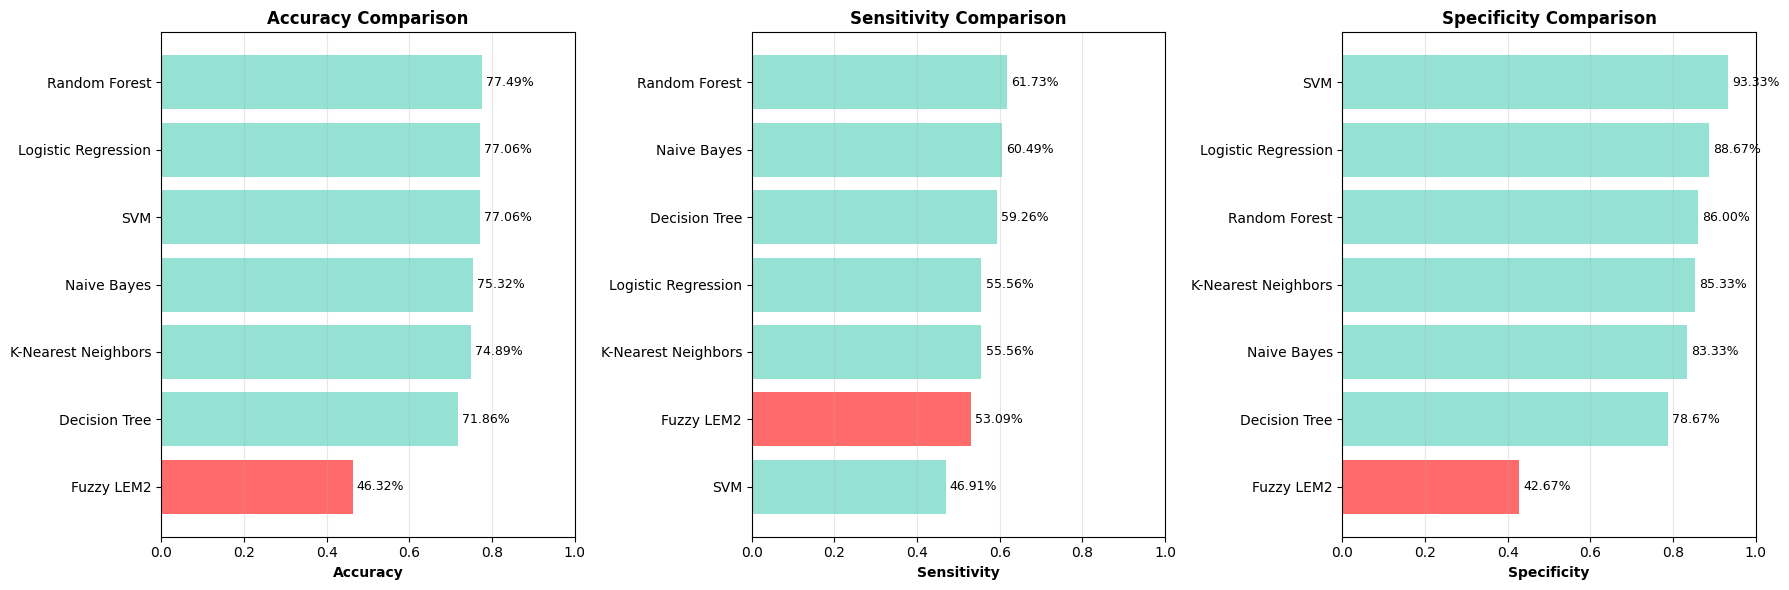

In [27]:
# Detailed comparison with medical metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['Accuracy', 'Sensitivity', 'Specificity']
for idx, metric in enumerate(metrics):
    sorted_df = comp_df.sort_values(metric, ascending=True)
    colors = ['#FF6B6B' if x == 'Fuzzy LEM2' else '#95E1D3' for x in sorted_df['Classifier']]
    
    bars = axes[idx].barh(sorted_df['Classifier'], sorted_df[metric], color=colors)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, sorted_df[metric])):
        axes[idx].text(val + 0.01, i, f'{val:.2%}', va='center', fontsize=9)
    
    axes[idx].set_xlabel(metric, fontweight='bold')
    axes[idx].set_title(f'{metric} Comparison', fontweight='bold')
    axes[idx].set_xlim(0, 1)
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

In [28]:
print("="*70)
print("🔍 SUMMARY")
print("="*70)
print(f"\n✅ Successfully trained Fuzzy LEM2 classifier on diabetes dataset")
print(f"\n📊 Key Results:")
print(f"   • Dataset: {X.shape[0]} samples, {X.shape[1]} features, {len(class_names)} classes")
print(f"   • Test Accuracy: {accuracy:.2%}")
print(f"   • Total Rules Generated: {sum(len(clf.rules_[i]) for i in range(len(class_names)))}")
print(f"   • Sensitivity (TPR): {per_class_data[1]['Recall']:.2%}")
print(f"   • Specificity (TNR): {per_class_data[0]['Recall']:.2%}")
print(f"\n💡 Key Observations:")
print(f"   • Diabetes prediction is a challenging medical classification task")
print(f"   • Fuzzy LEM2 generates interpretable if-then rules useful for clinical decisions")
print(f"   • Parameters (alpha, beta) significantly affect performance")
print(f"   • Balance between sensitivity and specificity is crucial in medical diagnosis")
print(f"\n⚕️ Medical Context:")
print(f"   • High sensitivity: Better at detecting diabetes (fewer false negatives)")
print(f"   • High specificity: Better at ruling out diabetes (fewer false positives)")
print(f"   • Rule-based approach allows medical professionals to understand decisions")
print("\n" + "="*70)

🔍 SUMMARY

✅ Successfully trained Fuzzy LEM2 classifier on diabetes dataset

📊 Key Results:
   • Dataset: 768 samples, 8 features, 2 classes
   • Test Accuracy: 46.32%
   • Total Rules Generated: 2
   • Sensitivity (TPR): 53.09%
   • Specificity (TNR): 42.67%

💡 Key Observations:
   • Diabetes prediction is a challenging medical classification task
   • Fuzzy LEM2 generates interpretable if-then rules useful for clinical decisions
   • Parameters (alpha, beta) significantly affect performance
   • Balance between sensitivity and specificity is crucial in medical diagnosis

⚕️ Medical Context:
   • High sensitivity: Better at detecting diabetes (fewer false negatives)
   • High specificity: Better at ruling out diabetes (fewer false positives)
   • Rule-based approach allows medical professionals to understand decisions

